In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# Sellers

🎯 Our goal is to find sellers who have repeatedly been underperforming vs. others, and understand why.  
This will help us shape our recommendations about how to improve Olist's profit margin for the future.

❗️ Long Notebook. Once you've read a section, you can collapse it.
<details>
    <summary> <i>[remainder] Notebook best practices</i></summary>

- Code your logic so that your Notebook can always be run from top to bottom without crashing (`Cell --> Run All`)
- Name your variables carefully 
- Use dummy names such as `tmp` for intermediary steps when you know you won't need them later
- Clear your code and merge cells when relevant to minimize Notebook size (`Shift-M`)
- Hide your cell output if you don't need to see it anymore (double click on the red `Out[]:` section to the left of your cell).
- Make heavy use of jupyter nbextention `Collapsable Headings` and `Table of Content` (call a TA if you can't find them)
- Use the following shortcuts 
    - `a` to insert a cell above
    - `b` to insert a cell below
    - `dd` to delete a cell
    - `esc` and `arrows` to move between cells
    - `Shift-Enter` to execute cell and move focus to the next one
    - use `Shift + Tab` when you're between method brackets e.g. `groupby()` to get the docs! Repeat a few times to open it permanently

</details>





## 1 - `olist/seller.py`  

In a process similar to `order.py`, we have coded for you the module `olist/seller.py` containing a class `Seller` with a method `Seller().get_training_data` that will return a DataFrame with the following features:
  
| feature_name 	| type 	| description 	|
|:---	|:---:	|:---	|
| `seller_id` 	| str 	| the id of the seller **UNIQUE** 	|
| `seller_city` 	| str 	| the city where seller is located 	|
| `seller_state` 	| str 	| the state where seller is located 	|
| `delay_to_carrier` 	| float 	| returns 0 if the order is delivered before the shipping_limit_date, otherwise the value of the delay 	|
| `wait_time` 	| float 	| average wait_time (duration of deliveries) per seller 	|
| `date_first_sale` 	| datetime 	| date of the first sale on Olist 	|
| `date_last_sale` 	| datetime 	| date of the last sale on Olist 	|
| `months_on_olist` 	| float 	| round number of months  on Olist	|
| `share_of_five_stars` 	| float 	| share of five-star reviews for orders in which the seller was involved 	|
| `share_of_one_stars` 	| float 	| share of one-star reviews for orders in which the seller was involved 	|
| `review_score` 	| float 	| average review score for orders in which the seller was involved 	|
| `n_orders` 	| int 	| number of unique orders the seller was involved with 	|
| `quantity` 	| int 	| total number of items sold by this seller 	|
| `quantity_per_order` 	| float 	| average number of items per order for this seller 	|
| `sales` 	| float 	| total sales associated with this seller (excluding freight value) in BRL 	|  

❓ **Import your new class below and check out your training dataframe !** Take time to look at the code and understand exactly what has been computed for you

In [1]:
from olist.seller import Seller

In [2]:
sellers = Seller().get_training_data()

In [3]:
print(sellers.shape)
sellers.head()

(2970, 12)


,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99


🤔 One last thing remains to be computed for each seller:
* the proportion of extremely high reviews (`share_of_five_stars`) and the proportion of extremely poor reviews (`share_of_one_stars`)
* the (average) `review_score`

😱 Each low-rated order will indeed have a negative impact on Olist's reputation and this is modeled by the `cost_of_review`.  

This will help us compute the total `cost_of_review` per seller later on!

❓ **Implement the last method that has been left for you `get_review_score()`**

In [5]:
from olist.data import Olist
data = Olist().get_data()

In [6]:
data.keys()

dict_keys(['sellers', 'order_reviews', 'order_items', 'customers', 'orders', 'order_payments', 'product_category_name_translation', 'products', 'geolocation'])

In [7]:
data['sellers'].columns

Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')

In [8]:
data['orders'].columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [10]:
data['order_reviews'].columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

In [11]:
data['order_items'].columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [14]:
df = data['order_items'][['order_id', 'seller_id']].merge(data['order_reviews'][['order_id', 'review_score']], on='order_id').drop(columns='order_id')

In [17]:
print(df.shape)
df.head()

(112372, 2)


,seller_id,review_score
0,48436dade18ac8b2bce089ec2a041202,5
1,dd7ddc04e1b6c2c614352b383efe2d36,4
2,5b51032eddd242adc84c38acab88f23d,5
3,9d7a1d34a5052409006425275ba1c2b4,4
4,df560393f3a51e74553ab94004ba5c87,5


In [19]:
df['share_of_five_stars'] = df['review_score'].map(lambda x: 1 if x==5 else 0)
df['share_of_one_stars'] = df['review_score'].map(lambda x: 1 if x==1 else 0)
df.head(10)

,seller_id,review_score,share_of_five_stars,share_of_one_stars
0,48436dade18ac8b2bce089ec2a041202,5,1,0
1,dd7ddc04e1b6c2c614352b383efe2d36,4,0,0
2,5b51032eddd242adc84c38acab88f23d,5,1,0
3,9d7a1d34a5052409006425275ba1c2b4,4,0,0
4,df560393f3a51e74553ab94004ba5c87,5,1,0
5,6426d21aca402a131fc0a5d0960a3c90,4,0,0
6,7040e82f899a04d1b434b795a43b4617,4,0,0
7,5996cddab893a4652a15592fb58ab8db,5,1,0
8,a416b6a846a11724393025641d4edd5e,1,0,1
9,ba143b05f0110f0dc71ad71b4466ce92,4,0,0


In [20]:
new_df = df.groupby('seller_id', as_index=False).agg({
    'review_score': 'mean',
    'share_of_five_stars': 'sum',
    'share_of_one_stars': 'sum'
})

In [21]:
new_df

,seller_id,review_score,share_of_five_stars,share_of_one_stars
0,0015a82c2db000af6aaaf3ae2ecb0532,3.666667,2,1
1,001cca7ae9ae17fb1caed9dfb1094831,3.902542,121,34
2,001e6ad469a905060d959994f1b41e4f,1.000000,0,1
3,002100f778ceb8431b7a1020ff7ab48f,3.982143,31,7
4,003554e2dce176b5555353e4f3555ac8,5.000000,1,0
...,...,...,...,...
3085,ffcfefa19b08742c5d315f2791395ee5,1.000000,0,1
3086,ffdd9f82b9a447f6f8d4b91554cc7dd3,4.250000,13,1
3087,ffeee66ac5d5a62fe688b9d26f83f534,4.214286,9,2
3088,fffd5413c0700ac820c7069d66d98c89,3.866667,33,11


🧪 Test your code below

In [22]:
from nbresult import ChallengeResult

tmp = Seller().get_training_data()
result = ChallengeResult('seller',
    shape = tmp.shape,
    median = tmp.review_score.median()
)
result.write()
print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /home/matheus/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/matheus/code/matheussposito/data-challenges-869/04-Decision-Science/03-Linear-Regression/02-Sellers
plugins: anyio-3.4.0
collecting ... collected 2 items

tests/test_seller.py::TestSeller::test_median_review_score PASSED        [ 50%]
tests/test_seller.py::TestSeller::test_shape PASSED                      [100%]

============================== 2 passed in 0.12s ===============================


💯 You can commit your code:

git add tests/seller.pickle

git commit -m 'Completed seller step'

git push origin master


## 2 - Sellers' Exploration

### (2.1) Plots

👉 Let's start with some initial ***`EDA - Exploratory Data Analysis`*** about these sellers.

- 📈 Plot the distribution of each numerical variable of the dataset in one large figure
- 👀 Do you notice any outliers?
- What's the median of orders per seller ❓
- How does the distribution of this variable look like ❓

In [24]:
sellers = Seller().get_training_data()

In [25]:
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,review_score,share_of_five_stars,share_of_one_stars
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,3.000000,1,1
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,4.560976,30,2
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,5.000000,1,0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99,5.000000,1,0
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99,1.000000,0,1


In [30]:
print(len(sellers.describe().columns))
sellers.describe().columns

10


Index(['delay_to_carrier', 'wait_time', 'months_on_olist', 'n_orders',
       'quantity', 'quantity_per_order', 'sales', 'review_score',
       'share_of_five_stars', 'share_of_one_stars'],
      dtype='object')

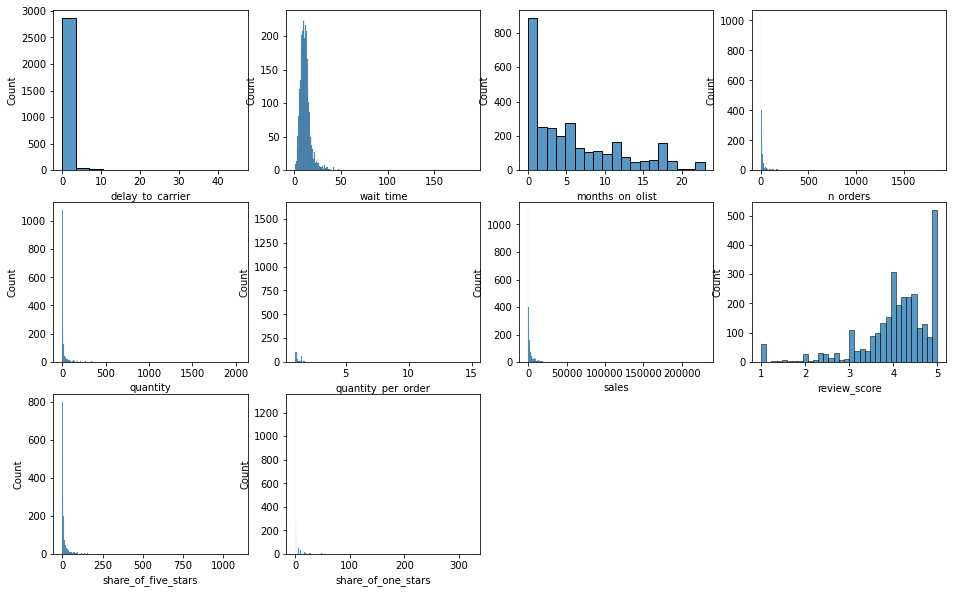

In [34]:
plt.figure(figsize=(16,10))
for i, col in enumerate(sellers.describe().columns):
    plt.subplot(3,4,1+i)
    sns.histplot(sellers[col])

💡There seems to be a group of sellers which stands out for having very low review scores! 

📊 Let's investigate graphically it:
* Using `plotly`, create a `scatterplot` of `delay_to_carrier` against `wait_time`, varying bubble size by total `sales` for that seller, and coloring by `review_score`. 

In [37]:
import plotly.express as px

In [42]:
px.scatter(x='wait_time', y='delay_to_carrier', data_frame=sellers, size='sales', size_max=60, color='review_score')

Feel free to change values `x`, `y`, `color` and `size` to try identify who are the worst sellers

### (2.2) Model out `review_score` with OLS

⚠️ Scatter plots have their limits. 

💡 A more rigorous way to explain **`sellers' review_score`** is to **model the impact of various features on `review_score` with a `multivariate-OLS` in `statsmodels`**.

👉 Create an OLS with numerical features of your choice. 

❓ What are the most impactful ones? 

⚠️ Don't forget to standardize your features using the `standardize`function below to compare the regression coefficients together. 

In [44]:
def standardize(df, features):
    df_standardized = df.copy()
    for f in features:
        mu = df[f].mean()
        sigma = df[f].std()
        df_standardized[f] = df[f].map(lambda x: (x - mu) / sigma)
    return df_standardized

In [45]:
features = ['delay_to_carrier', 'wait_time', 'n_orders', 'quantity', 'quantity_per_order', 'sales']
sellers_standardized = standardize(sellers, features)
model = smf.ols(formula=f"review_score ~ {'+ '.join(features)}", data=sellers_standardized).fit()

In [46]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     113.4
Date:                Tue, 26 Apr 2022   Prob (F-statistic):          4.42e-129
Time:                        20:47:30   Log-Likelihood:                -3329.4
No. Observations:                2967   AIC:                             6673.
Df Residuals:                    2960   BIC:                             6715.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.0749      0.014    298.308      0.000       4.048       4.102
delay_to_carrier      -0.1149      0.015     -7.423      0.000      -0.145      -0.085
wait_time             -0.2790      0.015    -18.033      0.000      -0.309      -0.249
n_orders               0.1830      0.122      1.499      0.134      -0.056       0.422
quantity              -0.2027      0.121     -1.674      0.094      -0.440       0.035
quantity_per_order    -0.0658      0.014     -4.748      0.000      -0.093      -0.039
sales                  0.0101      0.023      0.446      0.656      -0.034       0.055
==============================================================================
Omnibus:                      713.346   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2123.627
Skew:                          -1.230   Prob(JB):                         0.00
Kurtosis:                       6.335   Cond. No.                         20.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

📊 Draw a `bar_plot` with sorted coefficients.

In [47]:
model.params

Intercept             4.074920
delay_to_carrier     -0.114866
wait_time            -0.278974
n_orders              0.182975
quantity             -0.202666
quantity_per_order   -0.065799
sales                 0.010142
dtype: float64

<AxesSubplot:>

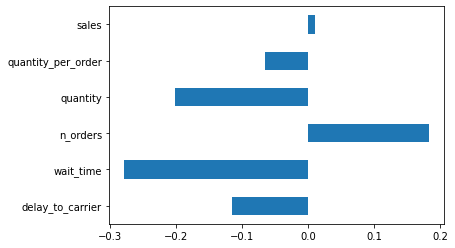

In [49]:
model.params[1:].plot(kind='barh')

👉 Finally, investigate your model's performance (`R-squared`) and `residuals`

In [50]:
model.rsquared

0.18684057694675693

In [52]:
predicted = model.predict(sellers_standardized.drop(columns='review_score'))

In [54]:
residuals = predicted - sellers_standardized['review_score']

<AxesSubplot:ylabel='Count'>

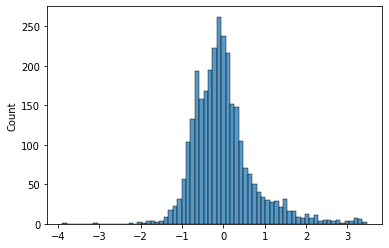

In [60]:
sns.histplot(residuals)

<AxesSubplot:>

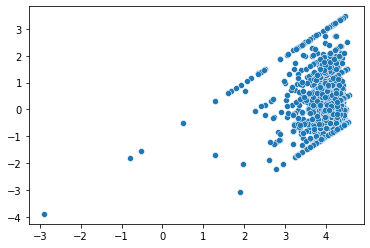

In [61]:
sns.scatterplot(x=predicted, y=residuals)

👉 Compare the real review scores and the predicted scores by showing them on the same graph.

<AxesSubplot:xlabel='review_score', ylabel='Density'>

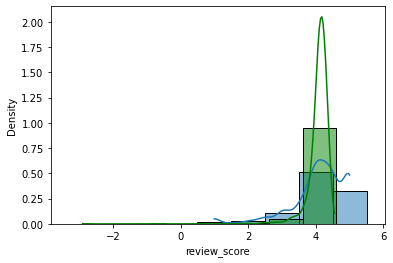

In [65]:
sns.histplot(sellers.review_score, kde=True, stat='density', discrete=True)
sns.histplot(predicted, kde=True, stat='density', discrete=True, color='g')

👉 Plot the residuals

<AxesSubplot:ylabel='Density'>

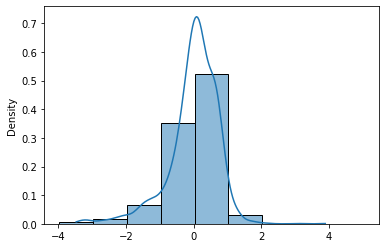

In [66]:
sns.histplot(model.resid, kde=True, stat='density', discrete=True)

### (2.3) Add the `seller_state` to your analysis

❓ We haven't used information about `seller_state` yet.  
- Create a new OLS model regressing `review_score` on only on `seller_states` .
- Analyse your significant features using `return_significative_coef(model)` coded for you in `olist/utils.py`
- What are the best states in terms of `review_score`? 

<details>
    <summary>- Hints -</summary>
        
⚠️ Be careful, `seller_state` is a categorical feature. 
    
💡 Use `C(a_cat_feature)` in the formula to tell the linear regression model which variables are categorical variables. It will create one boolean variable `is_cat_feature_xx` **per unique category** 

</details>

In [67]:
formula = 'review_score ~ C(seller_state)'
model2 = smf.ols(formula=formula, data=sellers).fit()

# top 5 coef with p-value < 0.05
from olist.utils import return_significative_coef
return_significative_coef(model2).tail()

,variable,p_value,coef
12,C(seller_state)[T.PE],0.041382,1.773696
1,C(seller_state)[T.BA],0.036514,1.772447
15,C(seller_state)[T.RJ],0.036379,1.731710
21,C(seller_state)[T.SP],0.037823,1.713781
3,C(seller_state)[T.DF],0.043756,1.690972


In [68]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8942
Date:                Tue, 26 Apr 2022   Prob (F-statistic):              0.599
Time:                        20:58:44   Log-Likelihood:                -3626.8
No. Observations:                2967   AIC:                             7298.
Df Residuals:                    2945   BIC:                             7429.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.3333      0.825      2.830      0.005       0.716       3.950
C(seller_state)[T.BA]     1.7724      0.847      2.092      0.037       0.111       3.434
C(seller_state)[T.CE]     1.3452      0.858      1.567      0.117      -0.338       3.028
C(seller_state)[T.DF]     1.6910      0.838      2.017      0.044       0.047       3.335
C(seller_state)[T.ES]     2.0472      0.843      2.428      0.015       0.394       3.700
C(seller_state)[T.GO]     1.7793      0.835      2.131      0.033       0.142       3.417
C(seller_state)[T.MA]     1.6692      1.166      1.431      0.152      -0.617       3.956
C(seller_state)[T.MG]     1.7786      0.826      2.152      0.031       0.158       3.399
C(seller_state)[T.MS]     1.9550      0.903      2.164      0.031       0.184       3.726
C(seller_state)[T.MT]     1.8756      0.922      2.034      0.042       0.068       3.683
C(seller_state)[T.PA]     2.1667      1.166      1.858      0.063      -0.120       4.453
C(seller_state)[T.PB]     1.9444      0.891      2.183      0.029       0.198       3.691
C(seller_state)[T.PE]     1.7737      0.869      2.041      0.041       0.069       3.478
C(seller_state)[T.PI]     1.7500      1.166      1.501      0.134      -0.537       4.037
C(seller_state)[T.PR]     1.7970      0.826      2.176      0.030       0.178       3.416
C(seller_state)[T.RJ]     1.7317      0.827      2.094      0.036       0.110       3.354
C(seller_state)[T.RN]     2.1526      0.903      2.383      0.017       0.381       3.924
C(seller_state)[T.RO]     1.5208      1.010      1.506      0.132      -0.459       3.501
C(seller_state)[T.RS]     1.7775      0.828      2.147      0.032       0.154       3.401
C(seller_state)[T.SC]     1.8158      0.827      2.196      0.028       0.195       3.437
C(seller_state)[T.SE]     1.5667      1.010      1.551      0.121      -0.414       3.547
C(seller_state)[T.SP]     1.7138      0.825      2.078      0.038       0.096       3.331
==============================================================================
Omnibus:                      839.677   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2215.413
Skew:                          -1.511   Prob(JB):                         0.00
Kurtosis:                       5.963   Cond. No.                         308.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

☝️ Some states indeed have _significantly_ better reviews than others on average. 

🤔 Is it due to some lower `quantity_per_order`, lower `wait_time`, or `delay_to_carrier`?  Or is it due to some other factors that we haven't collected data about?

❓ **Try to isolate the impact of the `seller_state` from the rest by adding other continuous features to your OLS until `seller_states` is no longer statistically siginificant!**

In [69]:
formula = 'review_score ~  sales + quantity + quantity_per_order + C(seller_state)'
model3 = smf.ols(formula=formula, data=sellers).fit()
return_significative_coef(model3).head(5+1)[1:]

,variable,p_value,coef
16,C(seller_state)[T.RN],0.016280,2.163358
4,C(seller_state)[T.ES],0.013824,2.069100
8,C(seller_state)[T.MS],0.029710,1.957293
11,C(seller_state)[T.PB],0.027844,1.952623
9,C(seller_state)[T.MT],0.040152,1.885717


In [70]:
formula = 'review_score ~ wait_time + C(seller_state)'
model3 = smf.ols(formula=formula, data=sellers).fit()
return_significative_coef(model3).head(5+1)[1:]

,variable,p_value,coef
22,wait_time,1.479050e-117,-0.047765


☝️ After adding `wait_time` to our analysis, none of the 22 dummy variables `is_seller_state_xx` are statistically signigicant:

Given our small dataset (most states have a very limited number of sellers):
- We _cannot conclude_ that "some states are inherently better than other for reasons that would be independent of the `wait_time`" 
- In other words, we _cannot reject the hypothesis_ that "seller_state has no impact on review_score, other than through `wait_time`"

🏁 Congratulations!

💾 Commit and push :
* your ` sellers.ipynb`notebook 
* as well as `seller.py`